# PyTorch and CIFAR10 data analysis

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

In [19]:
sns.set_theme(style='white', palette='pastel')

In [20]:
DATA_DIRS = {
    #'nogpu': os.path.join('csv', 'fast', '2021-10-19-11-31-50-nogpu'),
    'gpu': os.path.join('csv', 'fast', '2021-10-14-09-16-15-gpu'),
    # 'gpu-2': os.path.join('csv', 'cifar10-fast', '2021-10-14-12-30-14-gpu'),
    # 'gpu-3': os.path.join('csv', 'cifar10-fast', '2021-10-18-15-25-46-gpu'),
    'gpu-cpu1': os.path.join('csv', 'fast', '2021-10-21-15-02-56-gpu-cpu1'),
    'gpu-core1,3,5,7-nohyper': os.path.join('csv', 'fast', '2021-10-25-14-59-44-gpu-core1,3,5,7-nohyper'),
    'gpu-core1-hyper': os.path.join('csv', 'fast', '2021-10-22-12-07-40-gpu-core1-hyper'),
    'gpu-core1-nohyper': os.path.join('csv', 'fast', '2021-10-22-10-10-55-gpu-core1-nohyper')
}

In [21]:
dfs = {}

for name, data_dir in DATA_DIRS.items():
    run_filenames = (
        {int(file.name.split('-')[1][:-4]): file.name
         for file in sorted(list(os.scandir(data_dir)), key=lambda x: x.name)
         if file.is_file() and not file.name.startswith('.')}
    )

    df = pd.concat(
        [pd.concat({num: pd.read_csv(os.path.join(data_dir, filename), index_col='epoch')}, names=['run'])
         for num, filename in list(run_filenames.items())[1:]]
    )
    
    dfs[name] = df
    
df = pd.concat(dfs)
df.index.set_names(['setup', 'run', 'epoch'], inplace=True)

## Preview of the dataframe

In [22]:
df

duration  train acc  valid acc  package_0 energy  \
setup             run epoch                                                     
gpu               1   1      3.724672   0.410801     0.4697        380.612063   
                      2      3.716573   0.656834     0.6840        378.784491   
                      3      3.722800   0.742087     0.7070        379.495855   
                      4      3.724494   0.781713     0.7507        380.214481   
                      5      3.778247   0.806600     0.7418        386.181445   
...                               ...        ...        ...               ...   
gpu-core1-nohyper 50  20     3.728109   0.943782     0.9077        178.764802   
                      21     3.727907   0.953004     0.9162        184.318497   
                      22     3.768164   0.962911     0.9262        181.094019   
                      23     3.724416   0.970300     0.9330        181.688378   
                      24     3.728264   0.976301     0.9390        179.272734   

                             package_1 energy  dram_0 energy  dram_1 energy  \
setup             run epoch                                                   
gpu               1   1            360.305779      29.523814      32.484241   
                      2            362.672106      29.422726      32.309759   
                      3            363.518112      29.432763      32.424694   
                      4            363.270189      29.496946      32.439687   
                      5            373.224630      29.965953      33.058572   
...                                       ...            ...            ...   
gpu-core1-nohyper 50  20           208.925246      15.953662      32.808387   
                      21           209.672681      18.768097      32.821958   
                      22           211.336556      16.271963      33.243962   
                      23           212.680974      16.621002      32.886310   
                      24           209.309645      16.178357      32.800094   

                             nvidia_gpu_0 energy  nvidia_gpu_1 energy  \
setup             run epoch                                             
gpu               1   1                  771.310               89.789   
                      2                  772.754               89.849   
                      3                  773.320               90.075   
                      4                  774.393               89.798   
                      5                  775.343               91.253   
...                                          ...                  ...   
gpu-core1-nohyper 50  20                 764.664               89.743   
                      21                 764.576               89.918   
                      22                 766.778               90.496   
                      23                 763.972               89.737   
                      24                 763.887               89.671   

                             package_0 power  package_1 power  dram_0 power  \
setup             run epoch                                                   
gpu               1   1           102.186737        96.734906      7.926554   
                      2           101.917691        97.582411      7.916629   
                      3           101.938274        97.646412      7.906081   
                      4           102.084869        97.535448      7.919719   
                      5           102.211808        98.782489      7.931179   
...                                      ...              ...           ...   
gpu-core1-nohyper 50  20           47.950528        56.040539      4.279291   
                      21           49.442885        56.244069      5.034486   
                      22           48.058952        56.084753      4.318273   
                      23           48.783058        57.104523      4.462714   
                      24           48.084770     

## Epoch duration

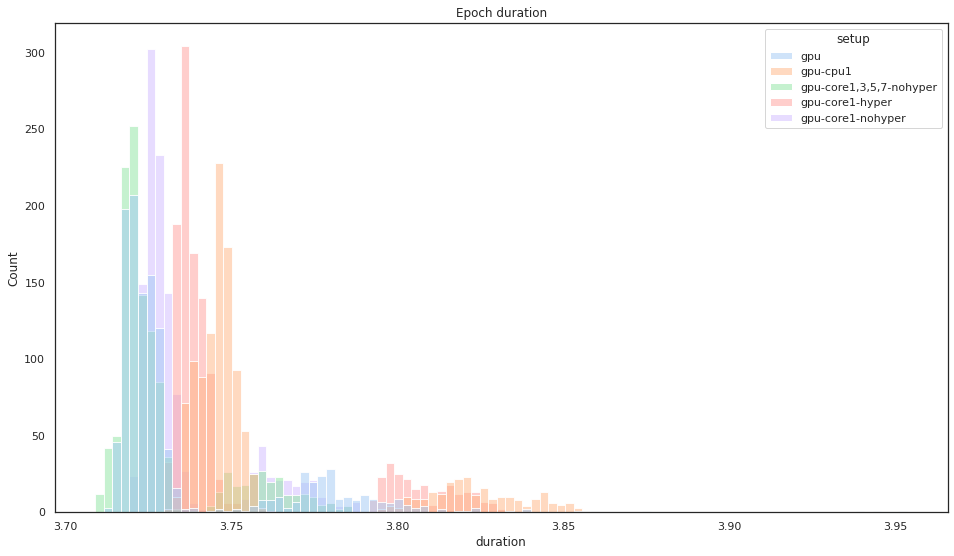

In [23]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.histplot(data=df, x='duration', hue='setup', kde=False, ax=ax)
ax.set_title('Epoch duration');
#ax.set_xlim(3.7, 3.875);

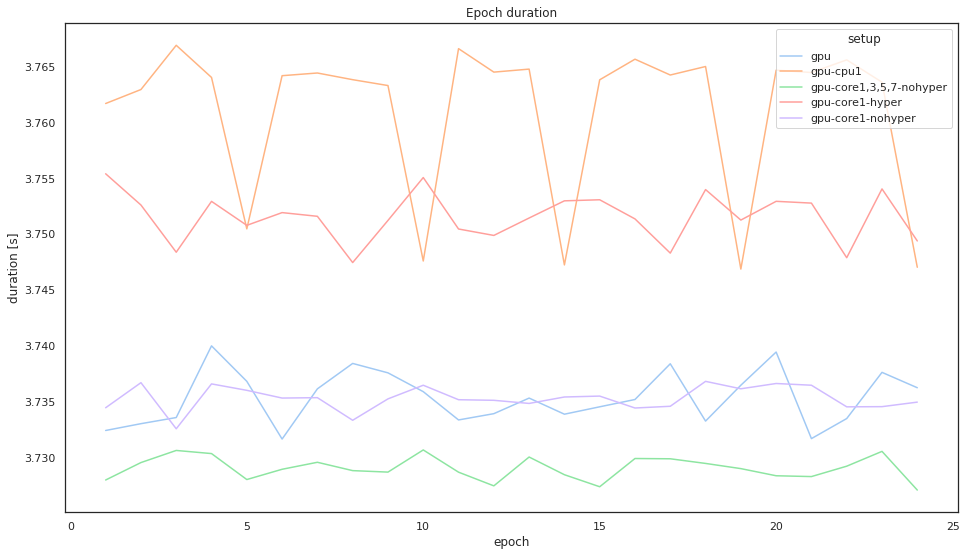

In [24]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(data=df, x='epoch', y='duration', hue='setup', ci=None, ax=ax)
ax.set_ylabel('duration [s]')
ax.set_title('Epoch duration');

## Accuracies over time

The objective of this model is to achieve 94% validation accuracy in the least amount of time. The desired accuracy is reached on most runs.

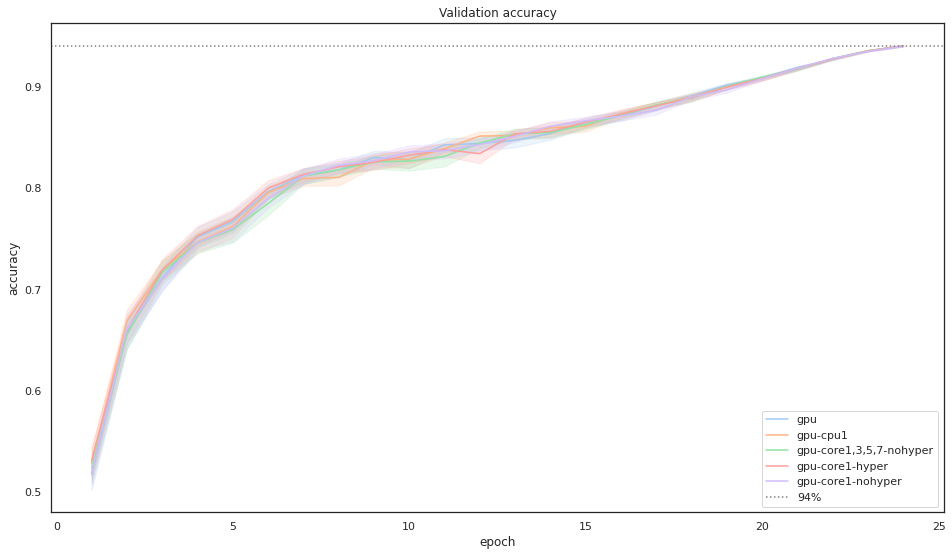

In [25]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(data=df, x='epoch', y='valid acc', hue='setup', ax=ax)
ax.axhline(0.94, linestyle=':', color='gray', label='94%')
ax.set_ylabel('accuracy')
ax.set_title('Validation accuracy')
ax.legend();

## Cumulative energy consumption versus epoch

In [26]:
df_sum_energy_setup = df.filter(regex='energy').sum(axis=1).groupby(level=['setup', 'run']).sum().unstack(level='setup')
df_sum_package_energy_setup = df.filter(regex='(?=.*package)(?=.*energy)').sum(axis=1).groupby(level=['setup', 'run']).sum().unstack(level='setup')
df_sum_gpu_energy_setup = df.filter(regex='(?=.*nvidia_gpu)(?=.*energy)').sum(axis=1).groupby(level=['setup', 'run']).sum().unstack(level='setup')

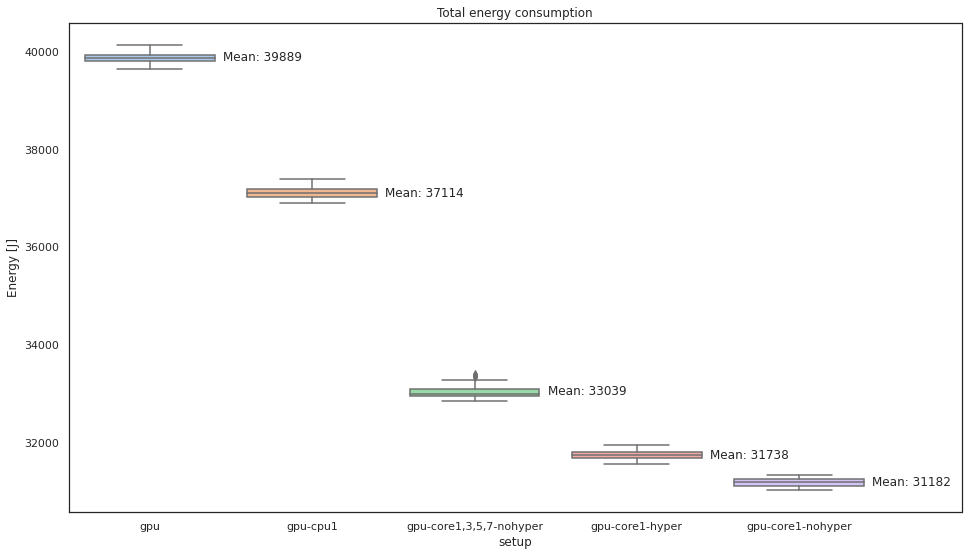

In [27]:
fig, ax = plt.subplots(figsize=(16, 9))

sns.boxplot(data=df_sum_energy_setup, ax=ax)
ax.set_title('Total energy consumption')
ax.set_ylabel('Energy [J]')
for x_pos, energy in zip(ax.get_xticks(), df_sum_energy_setup.mean()):
    ax.text(x_pos+0.45, energy, f'Mean: {round(energy)}', horizontalalignment='left', verticalalignment='center')
ax.set_xlim(ax.get_xticks()[0]-0.5, ax.get_xticks()[-1]+1);

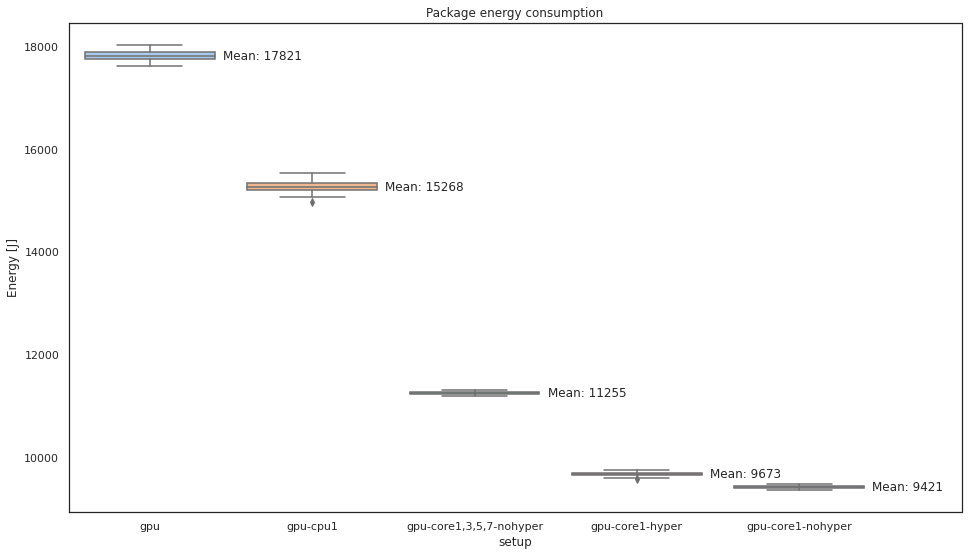

In [28]:
fig, ax = plt.subplots(figsize=(16, 9))

sns.boxplot(data=df_sum_package_energy_setup, ax=ax)
ax.set_title('Package energy consumption')
ax.set_ylabel('Energy [J]')
for x_pos, energy in zip(ax.get_xticks(), df_sum_package_energy_setup.mean()):
    ax.text(x_pos+0.45, energy, f'Mean: {round(energy)}', horizontalalignment='left', verticalalignment='center')
ax.set_xlim(ax.get_xticks()[0]-0.5, ax.get_xticks()[-1]+1);

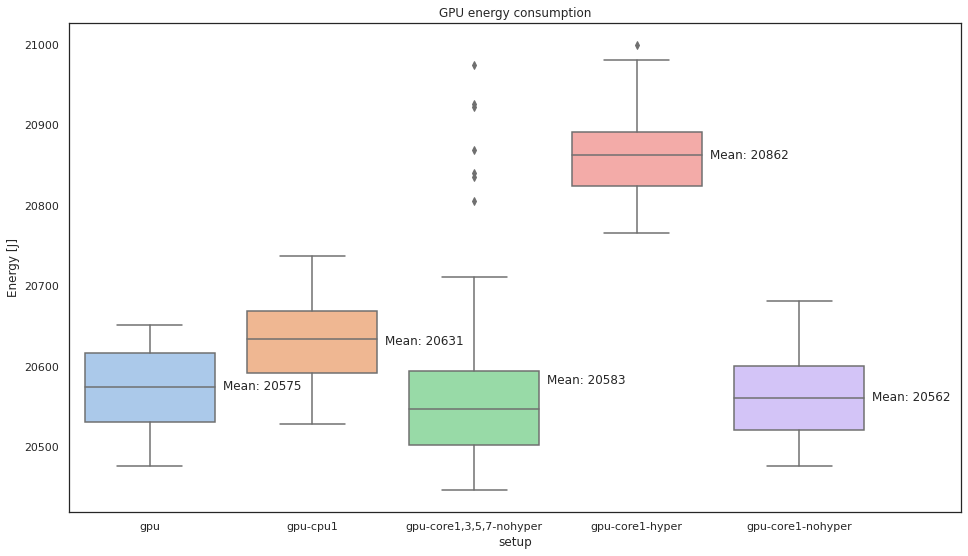

In [29]:
fig, ax = plt.subplots(figsize=(16, 9))

sns.boxplot(data=df_sum_gpu_energy_setup, ax=ax)
ax.set_title('GPU energy consumption')
ax.set_ylabel('Energy [J]')
for x_pos, energy in zip(ax.get_xticks(), df_sum_gpu_energy_setup.mean()):
    ax.text(x_pos+0.45, energy, f'Mean: {round(energy)}', horizontalalignment='left', verticalalignment='center')
ax.set_xlim(ax.get_xticks()[0]-0.5, ax.get_xticks()[-1]+1);

## Cumulative energy consumption versus accuracy

As validation accuracy increases, the energy required for subsequent improvements grows considerably.

In [30]:
df_cum_energy_validacc_setup = df.groupby(level=['setup', 'epoch']).mean().reset_index().set_index(['setup', 'valid acc']).filter(like='energy').sum(axis=1).unstack(level='setup').cumsum().interpolate(method='index').dropna()

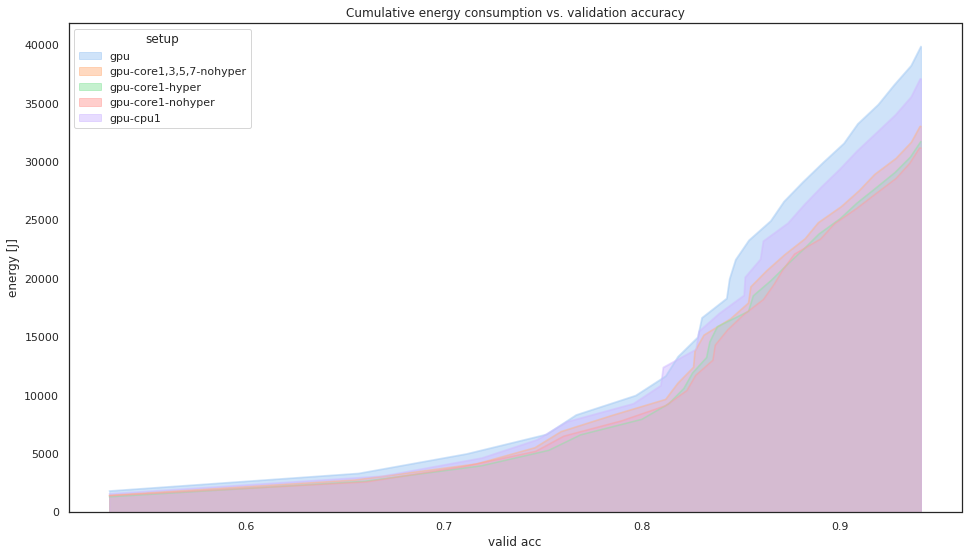

In [32]:
fig, ax = plt.subplots(figsize=(16, 9))
df_cum_energy_validacc_setup.plot.area(ylabel='energy [J]', title='Cumulative energy consumption vs. validation accuracy', stacked=False, ax=ax);

## Package power consumption

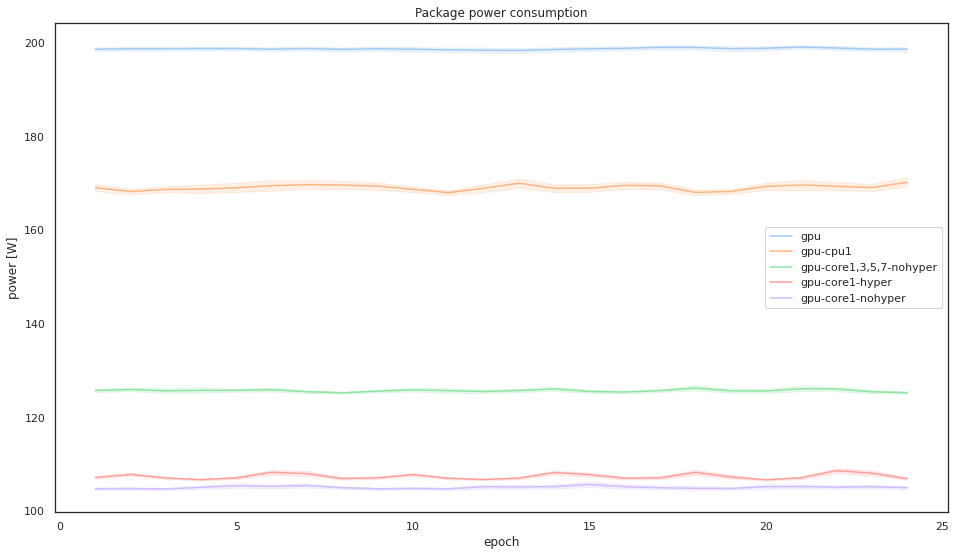

In [33]:
fig, ax = plt.subplots(figsize=(16, 9))
df['package power'] = df['package_0 power'] + df['package_1 power']
sns.lineplot(data=df, x='epoch', y='package power', hue='setup', ax=ax)
ax.set_ylabel('power [W]')
ax.set_title('Package power consumption')
ax.legend();

## GPU power consumption

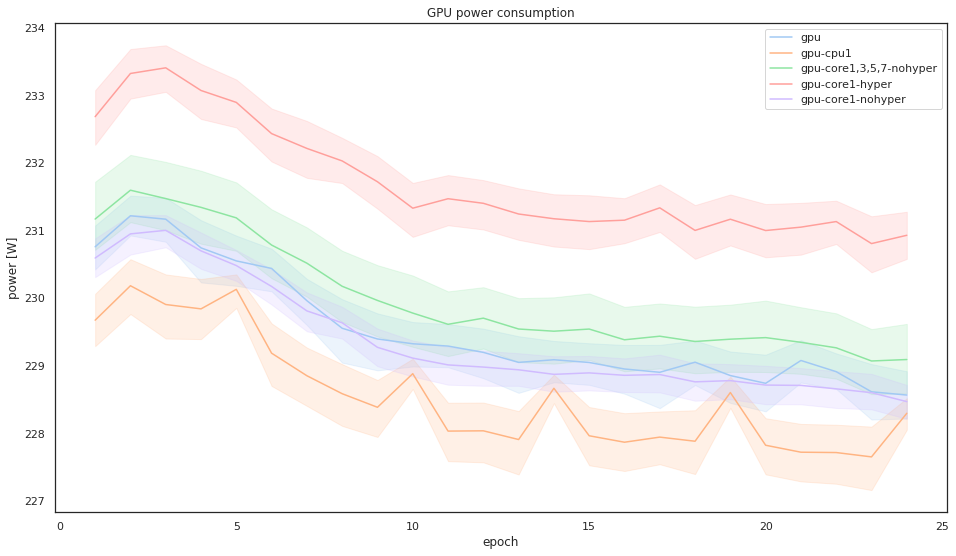

In [34]:
fig, ax = plt.subplots(figsize=(16, 9))
df['nvidia_gpu power'] = df['nvidia_gpu_0 power'] + df['nvidia_gpu_1 power']
sns.lineplot(data=df, x='epoch', y='nvidia_gpu power', hue='setup', ax=ax)
ax.set_ylabel('power [W]')
ax.set_title('GPU power consumption')
ax.legend();